In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from folium import plugins
from h3 import h3
from collections import defaultdict

In [65]:
df=pd.read_csv('/data/lab/STA326_Assignment2/datasets/data_orders.csv')
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [66]:
# preprocessing
df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Cancelled")
df.drop_duplicates(subset=['order_gk'], inplace=True)

## Task 1. 

Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

Reasons: 1.is_driver_assigned_key; 2.order_status_key(4 - by client, 9 - by system, i.e., a reject); 

###########################################

3.cancellations_time; 4.order_datetime

In [10]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,is_driver_assigned,order_status
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,Yes,Client Cancelled
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,No,Client Cancelled
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,Yes,Client Cancelled
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,Yes,Client Cancelled
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN,No,System Cancelled


In [14]:
df_failure_reason = df.groupby(by=['is_driver_assigned', 'order_status'])['order_gk'].count().reset_index()

# Renaming the count column for clarity
df_failure_reason.rename({'order_gk': 'Order Count'}, axis=1, inplace=True)
df_failure_reason

,is_driver_assigned,order_status,Order Count
0,No,Client Cancelled,4496
1,No,System Cancelled,3406
2,Yes,Client Cancelled,2811
3,Yes,System Cancelled,3


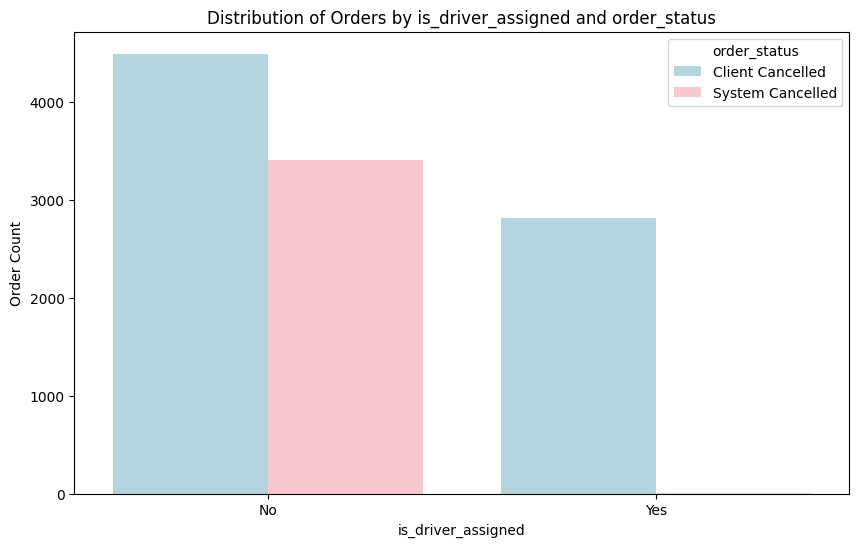

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_failure_reason, x="is_driver_assigned", y="Order Count", hue="order_status", palette=["lightblue", "pink"])
plt.xlabel("is_driver_assigned")
plt.ylabel("Order Count")
plt.title("Distribution of Orders by is_driver_assigned and order_status")
plt.show()

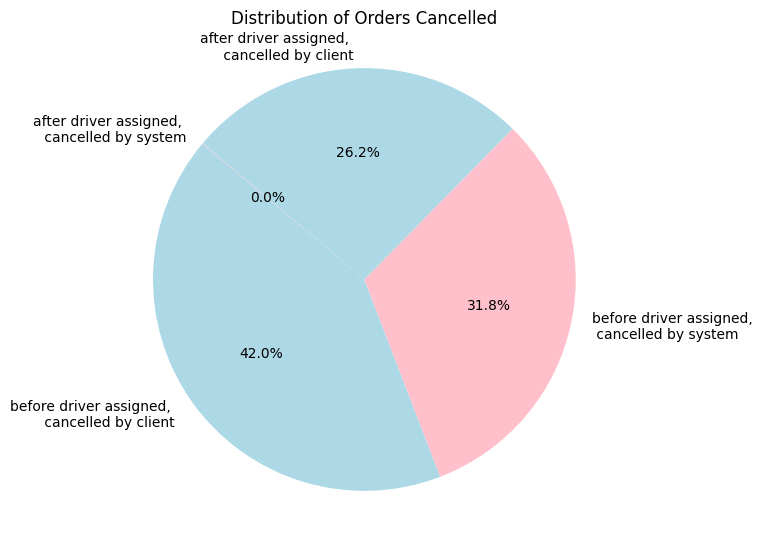

In [90]:
import matplotlib.pyplot as plt

# 计算每个分类组合的总订单数
total_order_counts = df_failure_reason.groupby(['is_driver_assigned', 'order_status'])['Order Count'].sum()

# 获取分类组合的标签
labels = ['before driver assigned, \n cancelled by client', 
          'before driver assigned, \n cancelled by system', 
          'after driver assigned, \n cancelled by client', 
          'after driver assigned, \n cancelled by system']

# 获取分类组合的订单数量
sizes = total_order_counts.values

# 绘制饼图
plt.figure(figsize=(6, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=["lightblue", "pink"])
plt.title("Distribution of Orders Cancelled")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# 调整标题和图之间的空间
plt.subplots_adjust(top=1.1)  # 可以根据需要调整值
plt.show()

From the figure, we can see that most of the orders have not been assigned drivers when they are canceled; In this section, orders cancelled by customers are the majority.

## Task 2.

Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

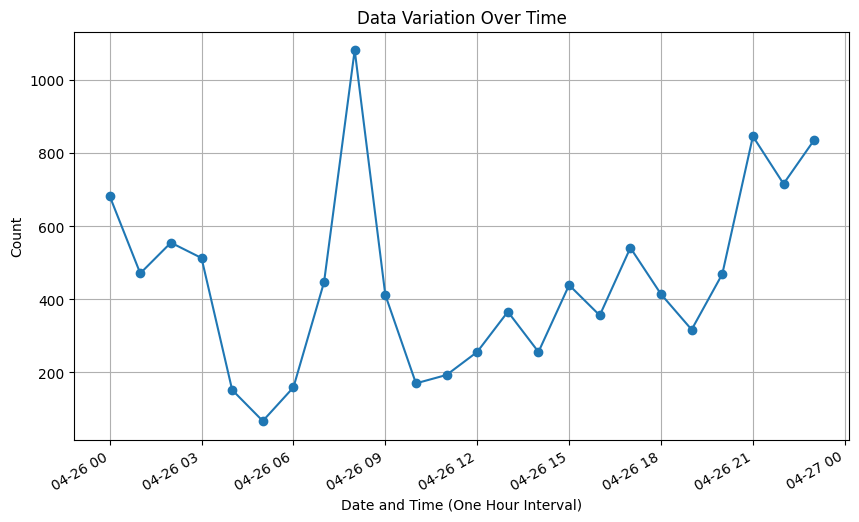

In [67]:
df['order_datetime'] = pd.to_datetime(df['order_datetime'])

# 按照半小时间隔进行分组，并计算每个半小时间隔内的数据数量
df['one_hour_group'] = df['order_datetime'].dt.floor('1h')

count_per_one_hour = df.groupby('one_hour_group').size()

# 设置画布大小
plt.figure(figsize=(10, 6))

# 绘制折线图
plt.plot(count_per_one_hour.index, count_per_one_hour.values, marker='o', linestyle='-')

# 添加标题和标签
plt.title('Data Variation Over Time')
plt.xlabel('Date and Time (One Hour Interval)')
plt.ylabel('Count')

# 自动旋转日期标签以避免重叠
plt.gcf().autofmt_xdate()

# 显示网格线
plt.grid(True)

# 显示图形
plt.show()

In [30]:
df_hour = df.groupby(by=['is_driver_assigned', 'order_status','one_hour_group'])['order_gk'].count().reset_index()
df_hour.head()

,is_driver_assigned,order_status,one_hour_group,order_gk
0,No,Client Cancelled,2024-04-26 00:00:00,298
1,No,Client Cancelled,2024-04-26 01:00:00,219
2,No,Client Cancelled,2024-04-26 02:00:00,237
3,No,Client Cancelled,2024-04-26 03:00:00,224
4,No,Client Cancelled,2024-04-26 04:00:00,50


/tmp/ipykernel_1203/247681172.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='one_hour_group', y='order_gk', hue='is_driver_assigned',style='order_status', markers=True,


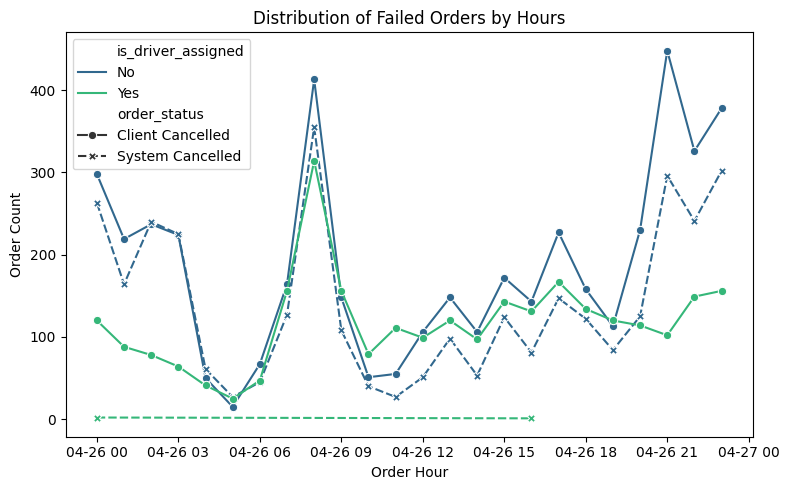

In [37]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='one_hour_group', y='order_gk', hue='is_driver_assigned',style='order_status', markers=True,
             data=df_hour, palette='viridis', ci=None)
plt.title('Distribution of Failed Orders by Hours')
plt.xlabel('Order Hour')
plt.ylabel('Order Count')
plt.tight_layout()

## Task 3.

Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

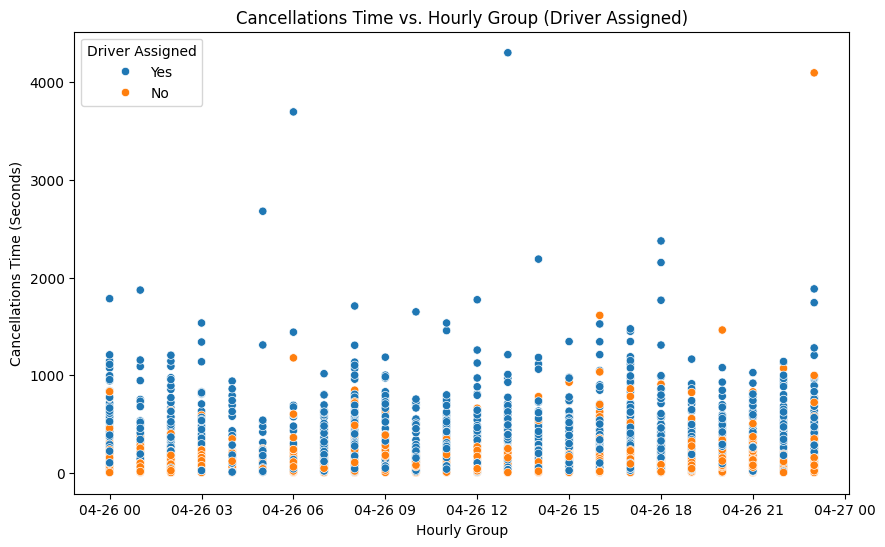

In [68]:
# 第一次画
###########################################
plt.figure(figsize=(10, 6))

# 绘制散点图
sns.scatterplot(data=df, x='one_hour_group', y='cancellations_time_in_seconds', hue='is_driver_assigned')

# 添加标题和标签
plt.title('Cancellations Time vs. Hourly Group (Driver Assigned)')
plt.xlabel('Hourly Group')
plt.ylabel('Cancellations Time (Seconds)')

# 显示图例
plt.legend(title='Driver Assigned')

# 显示图形
plt.show()

In [69]:
# 除去高杠杆点和异常值。切记不可反复运行这一段！！！
#############################
# 计算 Z 分数
df['z_score'] = (df['cancellations_time_in_seconds'] - df['cancellations_time_in_seconds'].mean()) 
/ df['cancellations_time_in_seconds'].std()

# 设置 Z 分数阈值，例如，超过 3 或 -3 的观测值被认为是异常值
z_threshold = 3

# 识别并移除异常值
df = df[np.abs(df['z_score']) <= z_threshold]

# # 使用 Tukey's fences 方法来识别异常值
# Q1 = df['cancellations_time_in_seconds'].quantile(0.25)
# Q3 = df['cancellations_time_in_seconds'].quantile(0.75)
# IQR = Q3 - Q1

# # 计算上下边界
# lower_fence = Q1 - 1.5 * IQR
# upper_fence = Q3 + 1.5 * IQR

# # 识别并移除异常值
# df = df[(df['cancellations_time_in_seconds'] >= lower_fence) & (df['cancellations_time_in_seconds'] <= upper_fence)]

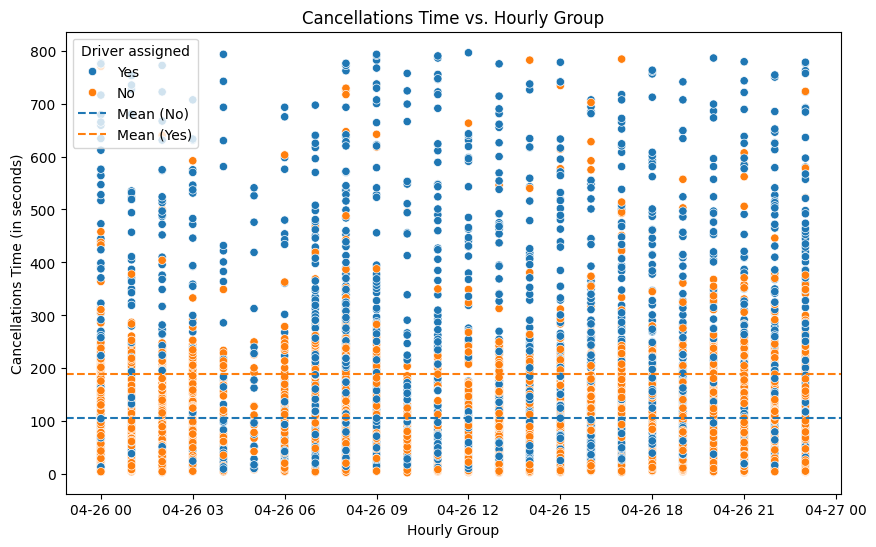

In [70]:
# 计算不同颜色点的均值
mean_values = df.groupby('is_driver_assigned')['cancellations_time_in_seconds'].mean()

# 绘制散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='one_hour_group', y='cancellations_time_in_seconds', hue='is_driver_assigned')

for color, mean_value in mean_values.items():
    plt.axhline(y=mean_value, color=sns.color_palette()[int(color == 'Yes')], linestyle='dashed', label=f'Mean ({color})')

# 添加标题和标签
plt.title('Cancellations Time vs. Hourly Group')
plt.xlabel('Hourly Group')
plt.ylabel('Cancellations Time (in seconds)')

# 显示图例
plt.legend(title='Driver assigned')

# 显示图形
plt.show()

/tmp/ipykernel_1203/2607300362.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='one_hour_group', y='cancellations_time_in_seconds', hue='is_driver_assigned', markers=True,


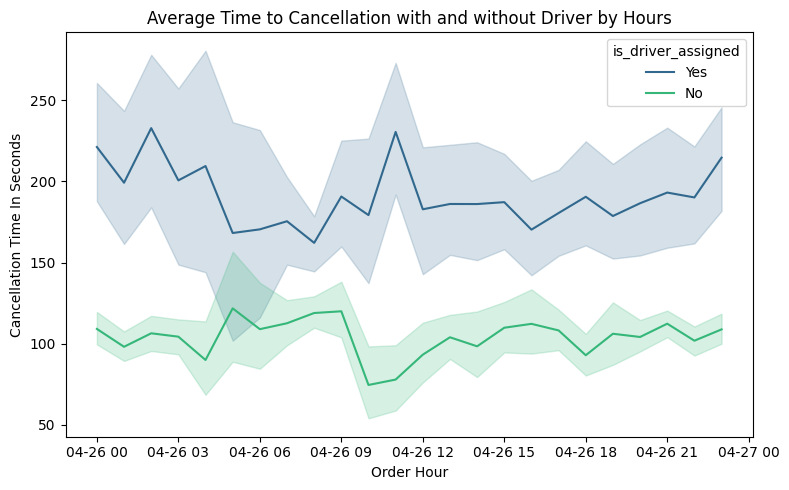

In [72]:
plt.figure(figsize=(8, 5))
# 同时绘制95%置信区间
sns.lineplot(x='one_hour_group', y='cancellations_time_in_seconds', hue='is_driver_assigned', markers=True,
             data=df, palette='viridis', ci=95, err_style="band")
plt.title('Average Time to Cancellation with and without Driver by Hours')
plt.xlabel('Order Hour')
plt.ylabel('Cancellation Time In Seconds')
plt.tight_layout()
plt.show()

## Task 4.

Plot the distribution of average ETA by hours. How can this plot be explained?

/tmp/ipykernel_1203/1015850787.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='one_hour_group', y='m_order_eta', markers=True,
/tmp/ipykernel_1203/1015850787.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='one_hour_group', y='m_order_eta', markers=True,
/tmp/ipykernel_1203/1015850787.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='one_hour_group', y='cancellations_time_in_seconds',markers=True,
/tmp/ipykernel_1203/1015850787.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='one_hour_group', y='cancellations_time_in_seconds',markers=True,


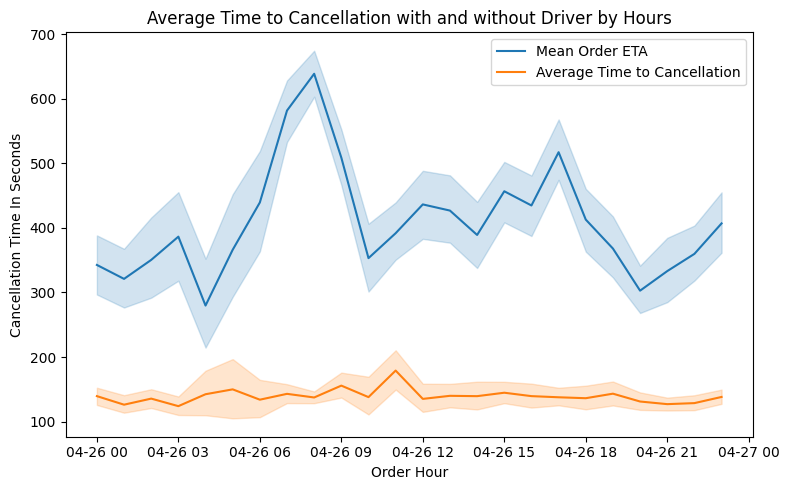

In [95]:
plt.figure(figsize=(8, 5))

# 同时绘制95%置信区间
sns.lineplot(x='one_hour_group', y='m_order_eta', markers=True,
             data=df, palette='viridis', ci=95, err_style="band", label='Mean Order ETA')

# 同时绘制取消前等待时间
sns.lineplot(x='one_hour_group', y='cancellations_time_in_seconds',markers=True,
             data=df, palette='viridis', ci=95, err_style="band", label='Average Time to Cancellation')

# 添加图例
plt.legend()

plt.title('Average Time to Cancellation with and without Driver by Hours')
plt.xlabel('Order Hour')
plt.ylabel('Cancellation Time In Seconds')
plt.tight_layout()
plt.show()

也可以加上每段时间的failed orders count

## Task 5. **BONUS** 

Hexagons. Using the [h3](https://github.com/uber/h3-py) and [folium](https://python-visualization.github.io/folium/latest/) packages, calculate how many sizes [8 hexes](https://h3geo.org/#/documentation/core-library/resolution-table) contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [135]:
import h3
from collections import defaultdict
df_offers = pd.read_csv("/data/lab/STA326_Assignment2/datasets/data_offers.csv")
merged_data = pd.merge(df, df_offers, on='order_gk', how='left')
# 创建一个 defaultdict 来存储每个六边形中订单的数量
hexagon_orders_count = defaultdict(int)

# 遍历原始数据集中的每个订单，计算其所在的 H3 六边形，并增加对应六边形的订单数量
for index, row in df.iterrows():
    lat = row['origin_latitude']
    lon = row['origin_longitude']
    hex_id = h3.geo_to_h3(lat, lon, 8)  # 使用尺寸为8的六边形
    hexagon_orders_count[hex_id] += 1

# 对订单数量进行排序
sorted_hexagons = sorted(hexagon_orders_count.items(), key=lambda x: x[1], reverse=True)

# 计算累积订单数量达到总订单数量80%的阈值的六边形的数量
total_orders = df.shape[0]
cumulative_orders = 0
for hex_id, order_count in sorted_hexagons:
    cumulative_orders += order_count
    if cumulative_orders >= total_orders * 0.8:
        break

# 输出结果
print("Number of size 8 hexagons containing 80% of all orders:", len(sorted_hexagons))

Number of size 8 hexagons containing 80% of all orders: 138


In [139]:
import h3

# 指定分辨率
resolution = 8

# 创建一个空的集合来存储地图上的所有六边形
hexagons_set = set()

# 遍历地图的所有点，并将它们转换为六边形，并添加到集合中
for lat in range(-90, 90):
    for lon in range(-180, 180):
        hex_id = h3.geo_to_h3(lat, lon, resolution)
        hexagons_set.add(hex_id)

# 计算集合中六边形的数量
num_hexagons = len(hexagons_set)
print("Number of hexagons on the map:", num_hexagons)
print("Number of size 8 hexagons containing 80% of all orders:", len(sorted_hexagons))

Number of hexagons on the map: 64441
Number of size 8 hexagons containing 80% of all orders: 138


In [130]:
for index, row in merged_data.iterrows():
    lat = row['origin_latitude']
    lon = row['origin_longitude']
    hex_id = h3.geo_to_h3(lat, lon, 8)
    if hex_id in top_hexagons and row['order_status_key'] in [4, 9]:
        hexagon_fail_count[hex_id] += 1

mean_lat = merged_data['origin_latitude'].mean()
mean_lon = merged_data['origin_longitude'].mean()
mymap = folium.Map(location=[mean_lat, mean_lon], zoom_start=10)

In [131]:
colormap = folium.LinearColormap(colors=['lightsalmon','darkred'], vmin=0, vmax=max(hexagon_fail_count.values()), caption='Fail Count')

for hex_id, fail_count in hexagon_fail_count.items():
    lat, lon = h3.h3_to_geo(hex_id)
    vertices = h3.h3_to_geo_boundary(hex_id)
    color = colormap(fail_count)
    folium.Polygon(locations=vertices, color=color, fill_color=color, fill_opacity=0.5, popup=f'Fail Count: {fail_count}').add_to(mymap)

colormap.add_to(mymap)
mymap

In [132]:
mymap.save('fails_map.html')